In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


![title](https://raw.githubusercontent.com/google/eng-edu/main/ml/recommendation-systems/images/softmax-model.png)

In [2]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [4]:
from fashion_recommendations.metrics.average_precision import mapk

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Datasets

In [6]:
from itertools import cycle, islice

import torch
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader

In [7]:
class FashionDatasetSingleLabel(IterableDataset):

    def __init__(self, dataset_filepath, max_length, padding_value):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.max_length = max_length
        
        self.padding_value = padding_value
    
    def process_label(self, label: str):

        return torch.tensor(int(label))
    
    def process_input(self, input_str: str, max_length, padding_value):
        
        input_tensor = torch.tensor([int(v) for v in input_str.split(',')])
        
        len_orig = len(input_tensor)
        
        if len_orig >= max_length:
            
            input_tensor = input_tensor[-max_length:]  # Take latest items
            
        else:
            
            num_pad = max_length - len_orig
            
            input_tensor = F.pad(input_tensor, (0, num_pad), value=padding_value)
            
        return input_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')  # [customer_id, label, input]
            
            label = self.process_label(line_items[1])
            
            input_seq = self.process_input(line_items[2], self.max_length, self.padding_value)

            yield input_seq, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

### fashrec-v1

- Use order history only
- Embedding for each item
- If item ordered X times index its embedding X times
- BoW of all item history embeddings
- For each customer take random transaction and roll-back data

### Train model

In [8]:
total_num_articles = pd.read_csv('data/articles.csv').shape[0]
total_num_articles

105542

In [9]:
class FashionRecV1(nn.Module):

    def __init__(self, mask_value, embedding_dim):
        super(FashionRecV1, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(num_embeddings=total_num_articles, embedding_dim=self.embedding_dim)
        
        self.fc_1 = nn.Linear(in_features=self.embedding_dim, out_features=128)            

        self.fc_2 = nn.Linear(in_features=128, out_features=total_num_articles)
        
        self.relu = nn.ReLU()
        
        self.tanh = nn.Tanh()

        self.dropout = nn.Dropout(0.3)
        
        self.mask_value = mask_value

    def forward(self, padded_sequences):
        
        x = self.embedding(padded_sequences)

        mask = padded_sequences != self.mask_value
        
        # Repeat mask so that shape matches output of embedding
        mask = torch.unsqueeze(mask, dim=2)
        mask = mask.repeat(1, 1, self.embedding_dim)

        x = mask * x
        
        # Compute average over non-padding embeddings:
        x = x.sum(dim=1)
        num_embeddings = mask[:, :, 0].sum(dim=1).reshape(-1, 1)  # Divide by number of (non-padding) embeddings to get mean embedding

        x = torch.div(
            x, 
            num_embeddings
        )

        x = self.fc_1(x)
        x = self.tanh(x)
        x = self.dropout(x)

        x = self.fc_2(x)
        x = self.tanh(x)
        
        return x

In [10]:
BATCH_SIZE = 512

In [11]:
total_training_examples = pd.read_csv('data/splits/train_single_purchase_label.tsv', sep='\t', low_memory=False).shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

2044.0

In [12]:
total_dev_examples = pd.read_csv('data/splits/dev_single_purchase_label.tsv', sep='\t', low_memory=False).shape[0]
total_dev_examples

62622

In [13]:
dev_actuals = pd.read_csv('data/splits/dev_all_purchase_label.tsv', sep='\t')['article_id_idx_label'].str.split(',').apply(lambda x: [int(i) for i in x]).tolist()

In [14]:
PADDING_VALUE = 0

In [15]:
fashion_rec_v1 = FashionRecV1(mask_value=PADDING_VALUE, embedding_dim=1024)

In [16]:
fashion_rec_v1.to(device)

FashionRecV1(
  (embedding): Embedding(105542, 1024)
  (fc_1): Linear(in_features=1024, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=105542, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v1.parameters(), lr=0.0001)

In [18]:
BATCH_SIZE_INFERENCE = 1024

In [19]:
MAX_EPOCHS = 3

In [20]:
EVAL_BATCH_INTERVAL = 2000

In [21]:
MAX_LENGTH_HISTORY = 100

In [22]:
training_losses = []
dev_losses = []
dev_maps = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = FashionDatasetSingleLabel(dataset_filepath='data/splits/train_single_purchase_label.tsv', max_length=MAX_LENGTH_HISTORY, padding_value=0)    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for idx, data in enumerate(tqdm(train_loader, total=total_batches)):
        
        X, y = data
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v1(X)
        
        loss = criterion(y_pred, y)  # Need index for loss in PyTorch

        loss.backward()    
        
        optimizer.step()
    
        # if idx % EVAL_BATCH_INTERVAL == 0:

        #     # Compute train loss
        #     train_dataset_for_loss = FashionDatasetSingleLabel(dataset_filepath='data/splits/train_single_purchase_label.tsv', max_length=MAX_LENGTH_HISTORY, padding_value=0)     
        #     total_train_loss = 0

        #     with torch.no_grad():
        #         for data in DataLoader(train_dataset_for_loss, batch_size=BATCH_SIZE_INFERENCE):
        #             X, y = data
        #             X, y = X.to(device), y.to(device)
        #             y_pred = fashion_rec_v1(X)
        #             loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, y).item()
        #             total_train_loss += loss

        #         mean_train_loss = total_train_loss / total_training_examples

        #         print(f"Training loss: {mean_train_loss}")
        #         training_losses.append(mean_train_loss)

        #     # Compute dev loss
        #     dev_dataset_for_loss = FashionDatasetSingleLabel(dataset_filepath='data/splits/dev_single_purchase_label.tsv', max_length=MAX_LENGTH_HISTORY, padding_value=0)     
        #     total_dev_loss = 0
        #     top_12_predictions = []

        #     with torch.no_grad():
        #         for data in DataLoader(dev_dataset_for_loss, batch_size=BATCH_SIZE_INFERENCE):
        #             X, y = data
        #             X, y = X.to(device), y.to(device)
        #             y_pred = fashion_rec_v1(X)
        #             loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, y).item()
        #             total_dev_loss += loss

        #             top_12 = y_pred.argsort(dim=1, descending=True)[:, :12].tolist()
        #             top_12_predictions += top_12

        #         mean_dev_loss = total_dev_loss / total_dev_examples

        #         print(f"Dev loss: {mean_dev_loss}")
        #         dev_losses.append(mean_dev_loss)

        #     # Compute dev MAP@12
        #     dev_mapk12 = mapk(dev_actuals, top_12_predictions, k=12)
        #     print(f"Dev MAP@12: {dev_mapk12}")
        #     dev_maps.append(dev_mapk12)

        #     time.sleep(5)

    # Compute end of epoch metrics
    train_dataset_for_loss = FashionDatasetSingleLabel(dataset_filepath='data/splits/train_single_purchase_label.tsv', max_length=MAX_LENGTH_HISTORY, padding_value=0)     
    total_train_loss = 0

    fashion_rec_v1.eval()

    with torch.no_grad():
        for data in DataLoader(train_dataset_for_loss, batch_size=BATCH_SIZE_INFERENCE):
            X, y = data
            X, y = X.to(device), y.to(device)
            y_pred = fashion_rec_v1(X)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, y).item()
            total_train_loss += loss

        mean_train_loss = total_train_loss / total_training_examples

        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)

    # Compute dev loss
    dev_dataset_for_loss = FashionDatasetSingleLabel(dataset_filepath='data/splits/dev_single_purchase_label.tsv', max_length=MAX_LENGTH_HISTORY, padding_value=0)     
    total_dev_loss = 0
    top_12_predictions = []

    with torch.no_grad():
        for data in DataLoader(dev_dataset_for_loss, batch_size=BATCH_SIZE_INFERENCE):
            X, y = data
            X, y = X.to(device), y.to(device)            
            y_pred = fashion_rec_v1(X)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, y).item()
            total_dev_loss += loss

            top_12 = y_pred.argsort(dim=1, descending=True)[:, :12].tolist()
            top_12_predictions += top_12

        mean_dev_loss = total_dev_loss / total_dev_examples

        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)

    # Compute dev MAP@12
    dev_mapk12 = mapk(dev_actuals, top_12_predictions, k=12)
    print(f"Dev MAP@12: {dev_mapk12}")
    dev_maps.append(dev_mapk12)

    time.sleep(5)

    fashion_rec_v1.train()

100%|██████████| 2044/2044.0 [01:42<00:00, 19.95it/s]


Training loss: 10.868403206738751
Dev loss: 11.233678394929347
Dev MAP@12: 0.0030367311423693693


100%|██████████| 2044/2044.0 [01:40<00:00, 20.33it/s]


Training loss: 10.73203340666917
Dev loss: 11.2103862713109
Dev MAP@12: 0.0030345626706499975


100%|██████████| 2044/2044.0 [01:40<00:00, 20.36it/s]


Training loss: 10.684267703515347
Dev loss: 11.207890143751897
Dev MAP@12: 0.0029406277547743935


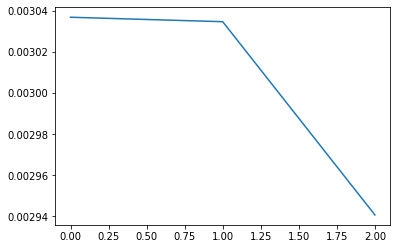

In [23]:
plt.plot(dev_maps)

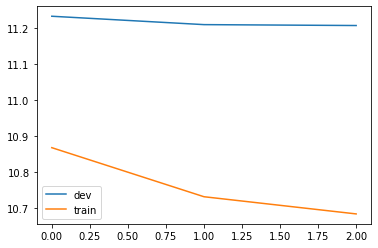

In [24]:
plt.plot(dev_losses, label='dev')
plt.plot(training_losses, label='train')
plt.legend()
plt.show()

In [25]:
fashion_rec_v1

FashionRecV1(
  (embedding): Embedding(105542, 1024)
  (fc_1): Linear(in_features=1024, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=105542, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [26]:
total_sub_batches = np.ceil(pd.read_csv('data/splits/submission_inputs.tsv', sep='\t').shape[0] / BATCH_SIZE_INFERENCE)
total_sub_batches

1340.0

In [27]:
submission_dataset = FashionDatasetSingleLabel(dataset_filepath='data/splits/submission_inputs.tsv', max_length=50, padding_value=0)     

top_12_predictions = []

with torch.no_grad():
    for data in tqdm(DataLoader(submission_dataset, batch_size=BATCH_SIZE_INFERENCE), total=total_sub_batches):
        X, _ = data
        X = X.to(device)
        y_pred = fashion_rec_v1(X)
        top_12 = y_pred.argsort(dim=1, descending=True)[:, :12].tolist()
        top_12_predictions += top_12

100%|██████████| 1340/1340.0 [02:25<00:00,  9.23it/s]


In [28]:
articles_df = pd.read_csv('data/articles.csv', dtype={'article_id': str})  # Make sure article_id is being loading in as a string
print(articles_df.shape)
articles_df.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [29]:
article_idx_to_id = dict(
    zip(
        articles_df.index + 2,
        articles_df['article_id']
    )
)

# Map to random article for 0 (pad) and 1 (no history) indices
article_idx_to_id[0] = '0108775015'
article_idx_to_id[1] = '0108775015'

In [30]:
top_12_predictions_df = pd.DataFrame(top_12_predictions)
print(top_12_predictions_df.shape)
top_12_predictions_df.head()

(1371980, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,70223,1715,53895,1716,24268,53894,42559,2254,76,32744,14242,67054
1,70223,24839,53894,42559,58493,3713,46384,1716,67524,2238,14255,57645
2,53895,24839,16005,17046,24268,1716,53894,2254,70223,1715,90084,58493
3,53895,3713,70223,47300,42559,53894,24268,56696,17385,67053,1716,58378
4,14242,1716,58493,24838,24839,53895,14255,16005,53894,2238,46384,24268


In [31]:
for col in range(12):
  top_12_predictions_df[col] = top_12_predictions_df[col].map(article_idx_to_id)

In [32]:
top_12_predictions_df.isnull().sum().sum()

0

In [33]:
top_12_predictions_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0759871002,0372860001,0706016002,0372860002,0608776002,0706016001,0673396002,0399256001,0160442007,0636323001,0562245001,0749699002
1,0759871002,0610776002,0706016001,0673396002,0720125001,0464297007,0685814001,0372860002,0751471001,0399223001,0562245046,0717490008
2,0706016002,0610776002,0568601006,0572797002,0608776002,0372860002,0706016001,0399256001,0759871002,0372860001,0841383002,0720125001
3,0706016002,0464297007,0759871002,0688537011,0673396002,0706016001,0608776002,0714790020,0573716012,0749699001,0372860002,0719655001
4,0562245001,0372860002,0720125001,0610776001,0610776002,0706016002,0562245046,0568601006,0706016001,0399223001,0685814001,0608776002


In [34]:
top_12_predictions_df['prediction'] = top_12_predictions_df[list(range(12))].agg(' '.join, axis=1)

In [35]:
final_submission = pd.read_csv('data/splits/submission_inputs.tsv', sep='\t')
final_submission.head()

,customer_id,dummy_label,article_id_idx_historical
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,999,"29518,101,30329,50726,16005,16005,23998,65669,..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,999,"19335,33750,33993,8218,41026,19335,42628,41026..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,999,"40181,10522,40181,18199,59460,1471,1471,60255,..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,999,"64527,61177"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,999,"32249,43444,51126,54463,2183,2183,20519,87478,..."


In [36]:
final_submission.shape, top_12_predictions_df.shape

((1371980, 3), (1371980, 13))

In [37]:
final_submission = pd.concat([final_submission, top_12_predictions_df], axis=1)[['customer_id', 'prediction']]
print(final_submission.shape)
final_submission.head()

(1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0759871002 0372860001 0706016002 0372860002 06...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0759871002 0610776002 0706016001 0673396002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016002 0610776002 0568601006 0572797002 06...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016002 0464297007 0759871002 0688537011 06...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0562245001 0372860002 0720125001 0610776001 06...


In [38]:
final_submission.to_csv('data/20220327-fashionrecv1_4.csv', index=False)

**Observations**

- IterableDataset facilitates use of full training data without exceeding memory constraints. Training is also fast.
- Whilst performance on dev set is good (MAP@12), performance on the competition dataset is always poor, only marginally beating the simple baseline
- We suspect this is because the model is not trained on data in the 2 weeks before the competition dataset. We reserved these for dev and test but we should train on this to provide the model with recent customer interaction data
- Validation should then be conducted as a series of folds where the training window is shifted
- We will create new splits following this strategy and run the model again